<a href="https://colab.research.google.com/github/starhou/notebooks/blob/master/ML/%E5%8D%B7%E7%A7%AF%E5%AD%A6%E4%B9%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 卷积核学习
致谢**zouxy09**撰写的优秀博文

[图像卷积与滤波的一些知识点](https://blog.csdn.net/zouxy09/article/details/49080029?spm=1001.2014.3001.5501)


2D卷积需要4个嵌套循环4-double loop，所以它并不快，除非我们使用很小的卷积核。这里一般使用3x3或者5x5。而且，对于滤波器，也有一定的规则要求：

      1）滤波器的大小应该是奇数，这样它才有一个中心，例如3x3，5x5或者7x7。有中心了，也有了半径的称呼，例如5x5大小的核的半径就是2。

      2）滤波器矩阵所有的元素之和应该要等于1，这是为了保证滤波前后图像的亮度保持不变。当然了，这不是硬性要求了。

      3）如果滤波器矩阵所有元素之和大于1，那么滤波后的图像就会比原图像更亮，反之，如果小于1，那么得到的图像就会变暗。如果和为0，图像不会变黑，但也会非常暗。

      4）对于滤波后的结构，可能会出现负数或者大于255的数值。对这种情况，我们将他们直接截断到0和255之间即可。对于负数，也可以取绝对值。


In [4]:
%tensorflow_version 2.x

In [7]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/

Mounted at /gdrive
/gdrive/My Drive


In [548]:
from __future__ import absolute_import, division, print_function, unicode_literals
# importing cv2 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg 

# TensorFlow and tf.keras
import tensorflow as tf
import cv2
import os
from tensorflow.keras import layers

from tensorflow import keras

# Helper libraries
import imageio
import time
from IPython import display
import PIL
import glob
from scipy import signal

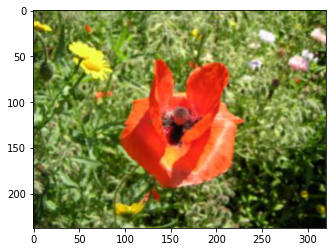

In [572]:
# path
path = './images/flower.jpg'
  
# # Using cv2.imread() method
img = mpimg.imread(path)
plt.imshow(img)
img = np.expand_dims(tf.constant(img, dtype=tf.float32), axis=0)
# img = cv2.imread(path)
# plt.imshow(img)

In [550]:
def MyLoadImg(path):
  img = mpimg.imread(path)
  plt.imshow(img)
  img = np.expand_dims(tf.constant(img, dtype=tf.float32), axis=0)
  return img

## 图像锐化滤波器Sharpness Filter

再在中心的位置加1，这样滤波后的图像就会和原始的图像具有同样的亮度了，但是会更加锐利

$$
\left[\begin{array}{rrr}
0 & -1 & 0 \\
-1 & 5 & -1 \\
0 & -1 & 0
\end{array}\right] ;\left[\begin{array}{rrr}
-1 & -1 & -1 \\
-1 & 9 & -1 \\
-1 & -1 & -1
\end{array}\right] ;\left[\begin{array}{rrr}
-k & -k & -k \\
-k & 8 k+1 & -k \\
-k & -k & -k
\end{array}\right]
$$

In [579]:
class SharpnessCov2D(keras.layers.Layer):
    def __init__(self, kw = 3, kh = 3, cin = 1, cout = 3):
        super(SharpnessCov2D, self).__init__()
        self.strides = 1
        self.padding='VALID'
        self.kernel = self.SharpnessKernal(kw, kh, cin, cout)
    def call(self, inputs):
        inputs = tf.constant(inputs, dtype=tf.float32)
        return tf.nn.conv2d(inputs, self.kernel, self.strides, self.padding)

    def SharpnessKernal(self, kw, kh, cin, cout):
      # kw: 核宽度
      # kh: 核高度
      # cin:  输入通道数
      # cout: 输出通道数
      print('kw', kw, ' kw ', kw, 'cin', cin, ' cout ', cout)
      if kw % 2 != 1:
        error("kw must be odd, please check")
      if kh % 2 != 1:
        error("kw must be odd, please check")
      w = int((kw - 1) / 2)
      h = int((kh - 1) / 2)
      print('w', w, ' h ', h)
      kernel_in = -1*np.ones((kw, kh, cin, cout))
      for i in range(cout):
        for j in range(cin):
          kernel_in[w][h][j][i] = 10
          kernel_in[w][h][j][i] = 10
          kernel_in[w][h][j][i] = 10
      return kernel_in        

kw 3  kw  3 cin 1  cout  3
w 1  h  1


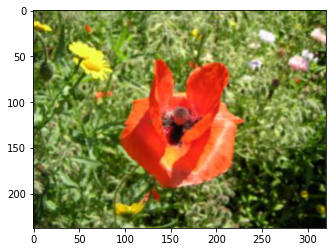

In [580]:
img = MyLoadImg(path)
sharpnessCov2D = SharpnessCov2D()
img = sharpnessCov2D(img)
img = np.squeeze(img.numpy(), axis=0)
img = np.interp(img, (img.min(), img.max()), (0, 255))
img = img.astype(int)

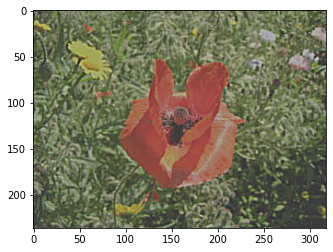

In [581]:
plt.imshow(img)

## 2.2 边缘检测Edge Detection

 我们要找水平的边缘：需要注意的是，这里矩阵的元素和是0，所以滤波后的图像会很暗，只有边缘的地方是有亮度的。

$$
\left[\begin{array}{rrr}
-1 / 8 & -1 / 8 & -1 / 8 \\
-1 / 8 & 1 & -1 / 8 \\
-1 / 8 & -1 / 8 & -1 / 8
\end{array}\right] ;\left[\begin{array}{rrr}
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1
\end{array}\right]
$$

In [601]:
class EdgeDetectCov2D(keras.layers.Layer):
    def __init__(self, kw = 3, kh = 3, cin = 1, cout = 3):
        super(EdgeDetectCov2D, self).__init__()
        self.strides = 1
        self.padding='VALID'
        self.kernel = self.EdgeDetectKernal(kw, kh, cin, cout)
    def call(self, inputs):
        inputs = tf.constant(inputs, dtype=tf.float32)
        return tf.nn.conv2d(inputs, self.kernel, self.strides, self.padding)

    def EdgeDetectKernal(self, kw = 3, kh = 3, cin = 3, cout = 3):
      # kw: 核宽度
      # kh: 核高度
      # cin:  输入通道数
      # cout: 输出通道数
      if kw % 2 != 1:
        error("kw must be odd, please check")
      if kh % 2 != 1:
        error("kw must be odd, please check")
      w = int((kw - 1) / 2)
      h = int((kh - 1) / 2)
      kernel_in = -1*np.ones((kw, kh, cin, cout))
      num = -1
      for i in range(cout):
        for j in range(cin):
          kernel_in[w][h][j][i] = num
          kernel_in[w][h][j][i] = num
          kernel_in[w][h][j][i] = num
      return kernel_in 

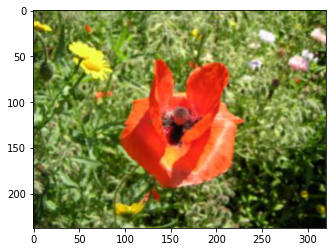

In [602]:
img = MyLoadImg(path)
edgeDetectCov2D = EdgeDetectCov2D()
img = edgeDetectCov2D(img)
img = np.squeeze(img.numpy(), axis=0)
img = np.interp(img, (img.min(), img.max()), (0, 1))
# img = img.astype(int)

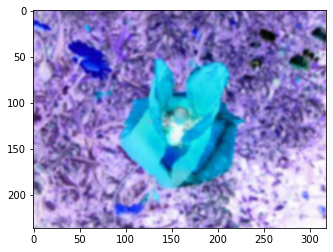

In [603]:
plt.imshow(img)

### 通用模型，可手动修改核，方便使用


In [625]:
class GeneralCov2D(keras.layers.Layer):
    def __init__(self, kernel = [[0,0,0],[0,1,0],[0,0,0]], cin = 1, cout = 3):
        super(GeneralCov2D, self).__init__()
        self.strides = 1
        self.padding='SAME'
        self.kernel = self.KernelGenerator(kernel, cin, cout)
    def call(self, inputs):
        inputs = tf.constant(inputs, dtype=tf.float32)
        return tf.nn.conv2d(inputs, self.kernel, self.strides, self.padding)

    def KernelGenerator(self,sourceKernel:list, cin, cout):
      kernel = np.array(sourceKernel)
      # print(kernel)
      w,h = cin,cout
      kernel = np.expand_dims(kernel, axis=-1)
      tempKernel = kernel
      for i in range(w-1):
        kernel = np.concatenate((kernel, tempKernel), axis = -1)
      # print(kernel)
      kernel = np.expand_dims(kernel, axis=-1)
      tempKernel = kernel
      for i in range(h-1):
        kernel = np.concatenate((kernel, tempKernel), axis = -1)
      # print(kernel)
      return kernel 

In [690]:
sourceKernel = [[1,2,3],[4,520,-1],[-2,-3,-4]]

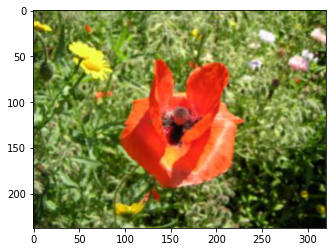

In [691]:
img = MyLoadImg(path)
generalCov2D = GeneralCov2D(sourceKernel)
img = generalCov2D(img)
img = np.squeeze(img.numpy(), axis=0)
img = np.interp(img, (img.min(), img.max()), (0, 1))
# img = img.astype(int)

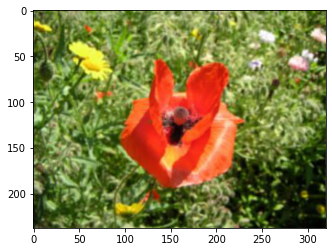

In [692]:
plt.imshow(img)

## 卷积的边界处理
    1. 第一种就是想象I是无限长的图像的一部分，除了我们给定值的部分，"SAME"
    2. 第二种方法也是想象I是无限图像的一部分。但没有指定的部分是用图像边界的值进行拓展
    3. 第三种情况就是认为图像是周期性的。也就是I不断的重复。周期就是I的长度
    4. 后一种情况就是不管其他地方了。我们觉得I之外的情况是没有定义的，所以没办法使用这些没有定义的值，所以要使用图像I没有定义的值的像素都没办法计算。在这里，J(1)和J(10)都没办法计算，所以输出J会比原图像I要小。